In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import orekit

In [2]:
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate
from org.orekit.utils import ExtendedPVCoordinatesProvider
from org.orekit.orbits import OrbitType, KeplerianOrbit, EquinoctialOrbit, PositionAngle
from org.orekit.propagation.semianalytical.dsst import DSSTPropagator
from org.orekit.propagation import PropagationType
from org.orekit.propagation.semianalytical.dsst.forces import DSSTZonal, DSSTTesseral
from org.orekit.propagation import SpacecraftState
from org.orekit.frames import FramesFactory
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity.potential import GravityFieldFactory
from orekit import JArray_double
from org.orekit.bodies import CelestialBodyFactory, CelestialBody,OneAxisEllipsoid
from org.orekit.utils import IERSConventions
from org.orekit.utils import Constants

In [3]:
vm = orekit.initVM()
setup_orekit_curdir("../../../orekit-data.zip")

In [4]:
def frozen(body_shape, celestial_body, **kwargs):
    """Computes keplerian elements of frozen orbit.
    All units are SI.
    """
    a = kwargs["a"] if "a" in kwargs else None
    i = kwargs["i"] if "i" in kwargs else np.deg2rad(63.44)
    w = np.deg2rad(90)
    raan = kwargs["raan"] if "raan" in kwargs else None

    # constants
    R = body_shape.getEquatorialRadius()
    J2 = 0.108265e-2
    J3 = -0.254503e-5
    mu = celestial_body.getGM()

    time = kwargs["time"] if "time" in kwargs else datetime.datetime.utcnow()

    if a is not None:
        e = -0.5 * J3 / J2 * (R / a) * np.sin(i) * np.sin(w)
    else:
        raise ValueError(
            "Insufficient arguments to compute frozen orbit. Provide a.")

    return w, e


In [5]:
# simulation times
t_start = datetime.datetime.utcnow()
duration = 200 * 24 * 60 * 60
t_end = t_start + datetime.timedelta(seconds=duration)
step_size = 24*60*60
# orekit times
t_start_ok = datetime_to_absolutedate(t_start)
t_end_ok = datetime_to_absolutedate(t_end)

In [6]:
time_vec_orekit = [t_start_ok.shiftedBy(float(dt)) for dt in np.arange(0, duration, step_size)]


In [7]:
inertial_frame = FramesFactory.getEME2000()

In [8]:
earth_frame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

In [9]:
# earth position velocity object
earth = CelestialBodyFactory.getEarth()
earth_pv = ExtendedPVCoordinatesProvider.cast_(earth)

# earth shape: an ellipsoid
earth_shape = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                               Constants.WGS84_EARTH_FLATTENING, earth_frame)


In [10]:
sun =  CelestialBodyFactory.getSun()

In [11]:
a = 6945.137e3
i = np.deg2rad(97.6585)
w, e = frozen(earth_shape, earth, a=a, i=i)
raan = 0

In [12]:
e

0.0010697851456007749

In [13]:
e_all = [1.05*e, 0.99*e, 1.1*e, 1.01*e, 1.03*e]

In [14]:
lines = []
ecc_centers  = []

eccentricity: 0.0012174319561799318
eccentricity: 0.0012213868208147116
eccentricity: 0.001214138380477339
eccentricity: 0.0012200682222767347
eccentricity: 0.0012187499336999766


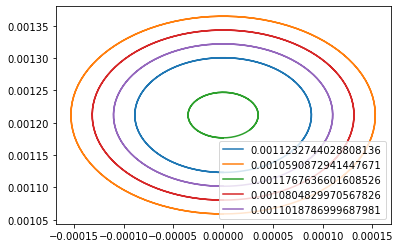

In [15]:
for e in e_all:
    initial_state = SpacecraftState(
    EquinoctialOrbit(float(a), float(e * np.cos(w + 0)),
                        float(e * np.sin(w + 0)),
                        float(np.tan(i / 2) * np.cos(0)),
                        float(np.tan(i / 2) * np.sin(0)), float(0 + w + 0),
                        PositionAngle.MEAN, inertial_frame,
                        t_start_ok, earth.getGM()),
    float(100.0))
    min_step = float(86400.0)
    max_step = float(86400.0)
    position_tolerance = float(1.0)
    orbit_type = OrbitType.EQUINOCTIAL
    tolerances = DSSTPropagator.tolerances(position_tolerance, float(1e-3),
                                            initial_state.getOrbit())
    integrator = DormandPrince853Integrator(min_step, max_step,
                                            JArray_double.cast_(tolerances[0]),
                                            JArray_double.cast_(tolerances[1]))
    propagator = DSSTPropagator(integrator, PropagationType.MEAN)
    zonal_force = DSSTZonal(GravityFieldFactory.getUnnormalizedProvider(21, 21))
    tesseral_force = DSSTTesseral(earth_frame, float(2*np.pi/86400), GravityFieldFactory.getUnnormalizedProvider(21, 21))
    propagator.addForceModel(zonal_force)
    propagator.setInitialState(initial_state, PropagationType.MEAN)
    sc_data = [propagator.propagate(t) for t in time_vec_orekit]
    sma_propagated = [s.getA() / 1e3 for s in sc_data]
    i_propagated = [s.getI() for s in sc_data]
    e_propagated = []
    w_propagated = []
    raan_propagated = []
    mean_anomaly_propagated = []
    for state in sc_data:
        keplerian = KeplerianOrbit.cast_(
            OrbitType.KEPLERIAN.convertType(state.getOrbit()))
        e_propagated.append(keplerian.getE())
        w_propagated.append(keplerian.getPerigeeArgument())
        raan_propagated.append(keplerian.getRightAscensionOfAscendingNode())
        mean_anomaly_propagated.append(keplerian.getAnomaly(PositionAngle.MEAN))

    ex = np.multiply(np.array(e_propagated),
                        np.cos(np.array(w_propagated)))
    ey = np.multiply(np.array(e_propagated),
                        np.sin(np.array(w_propagated)))
    center = np.linalg.norm([np.mean(ex), np.mean(ey)])
    print(f"eccentricity: {center}")
    ecc_centers.append(center)
    ax = plt.plot(ex, ey)
    lines.append(ax[0])
plt.legend(lines, e_all)


In [16]:
average_center = np.mean(ecc_centers)
average_center

0.0012183550626897388

In [17]:
initial_state = SpacecraftState(
    EquinoctialOrbit(float(a), float(e * np.cos(w + 0)),
                        float(e * np.sin(w + 0)),
                        float(np.tan(i / 2) * np.cos(0)),
                        float(np.tan(i / 2) * np.sin(0)), float(0 + w + 0),
                        PositionAngle.MEAN, inertial_frame,
                        t_start_ok, earth.getGM()),
    float(100.0))

In [18]:
min_step = float(86400.0)
max_step = float(86400.0)
position_tolerance = float(1.0)
orbit_type = OrbitType.EQUINOCTIAL
tolerances = DSSTPropagator.tolerances(position_tolerance, float(1e-3),
                                        initial_state.getOrbit())
integrator = DormandPrince853Integrator(min_step, max_step,
                                        JArray_double.cast_(tolerances[0]),
                                        JArray_double.cast_(tolerances[1]))


In [19]:
propagator = DSSTPropagator(integrator, PropagationType.MEAN)
zonal_force = DSSTZonal(GravityFieldFactory.getUnnormalizedProvider(21, 21))
tesseral_force = DSSTTesseral(earth_frame, float(2*np.pi/86400), GravityFieldFactory.getUnnormalizedProvider(21, 21))
propagator.addForceModel(zonal_force)
propagator.setInitialState(initial_state, PropagationType.MEAN)


In [20]:
sc_data = [propagator.propagate(t) for t in time_vec_orekit]

In [21]:
sma_propagated = [s.getA() / 1e3 for s in sc_data]
i_propagated = [s.getI() for s in sc_data]
e_propagated = []
w_propagated = []
raan_propagated = []
mean_anomaly_propagated = []
for state in sc_data:
    keplerian = KeplerianOrbit.cast_(
        OrbitType.KEPLERIAN.convertType(state.getOrbit()))
    e_propagated.append(keplerian.getE())
    w_propagated.append(keplerian.getPerigeeArgument())
    raan_propagated.append(keplerian.getRightAscensionOfAscendingNode())
    mean_anomaly_propagated.append(keplerian.getAnomaly(PositionAngle.MEAN))

In [22]:
eq_ex = [s.getEquinoctialEx() for s in sc_data]
eq_ey = [s.getEquinoctialEy() for s in sc_data]
hx = [s.getHx() for s in sc_data]
hy = [s.getHy() for s in sc_data]

sum_w_raan = np.arctan2(eq_ey, eq_ex)
raan = np.arctan2(hy, hx)
mean_anomaly_equinoctial = np.array([s.getLM() for s in sc_data]) - sum_w_raan
mean_anomaly_equinoctial = mean_anomaly_equinoctial % (2*np.pi)

w_propagated_equinoctial = sum_w_raan - raan

e_propagated_equinoctial = np.linalg.norm(np.vstack((np.array(eq_ex), np.array(eq_ey))), axis=0)

ex = np.multiply(np.array(e_propagated),
                    np.cos(np.array(w_propagated)))
ey = np.multiply(np.array(e_propagated),
                    np.sin(np.array(w_propagated)))


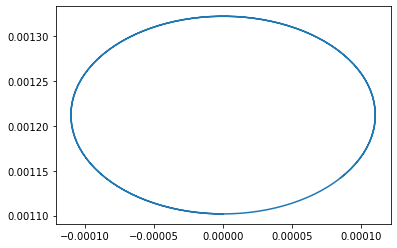

In [23]:
plt.plot(ex, ey)

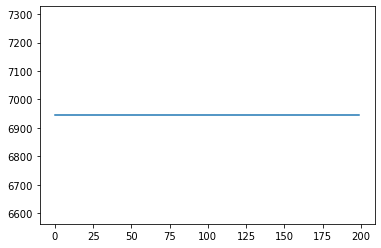

In [24]:
plt.plot(sma_propagated)

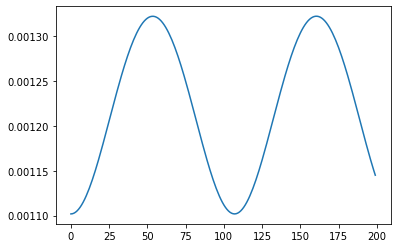

In [25]:
plt.plot(e_propagated)

In [44]:
i_propagated[-1]==i_propagated[1]

False

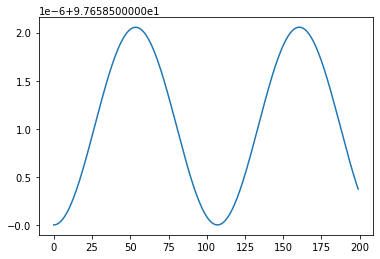

In [47]:
f_inc = plt.figure('inclination')
ax_i = f_inc.add_subplot(111)
ax_i.plot(np.rad2deg(np.array(i_propagated)))
# ax_i.set_ylim([97.65, 97.66])

Text(0.5, 0, 'steps')

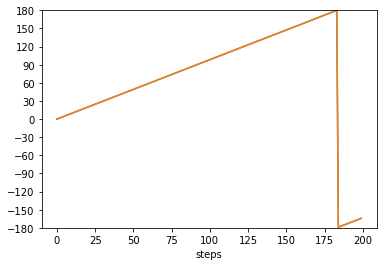

In [27]:
f_raan = plt.figure("raan")
ax_raan = f_raan.add_subplot(111)
ax_raan.plot(np.rad2deg(np.array(raan_propagated)))
ax_raan.plot(np.rad2deg(raan))
ax_raan.set_ylim(-180, 180)
ax_raan.set_yticks(np.arange(-180, 210, 30))
ax_raan.set_xlabel("steps")

Text(0.5, 0, 'steps')

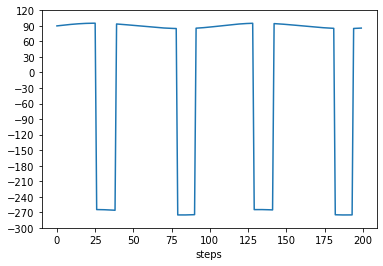

In [28]:
f = plt.figure("perigee")
ax_perigee = f.add_subplot(111)
ax_perigee.plot(np.rad2deg(np.array(w_propagated)))
ax_perigee.set_ylim(-270, 90)
ax_perigee.set_yticks(np.arange(-300, 150, 30))
ax_perigee.set_xlabel("steps")

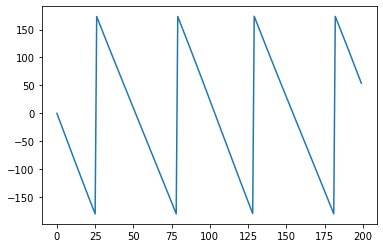

In [29]:
f = plt.figure("mean_anomaly")
ax_ma = f.add_subplot(111)
ax_ma.plot(np.rad2deg(np.array(mean_anomaly_propagated)))


Text(0.5, 0, 'steps')

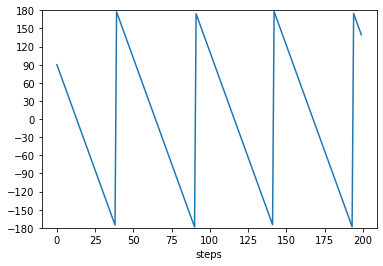

In [30]:
f = plt.figure("arg_latitude")
ax_arg_lat = f.add_subplot(111)
ax_arg_lat.plot(np.rad2deg(np.array(mean_anomaly_propagated) + np.array(w_propagated)))
ax_arg_lat.set_ylim(-180, 180)
ax_arg_lat.set_yticks(np.arange(-180, 210, 30))
ax_arg_lat.set_xlabel("steps")